# Exploratory Data Analysis (EDA): TEA UV-Vis Spectra

This notebook performs exploratory data analysis (EDA) on the TEA UV-Vis spectral dataset.
Topics covered:

- Data loading
- Dataset structure and metadata
- Wavelength inspection
- Sample distribution and metadata properties
- Visualization of spectra
- Variance across samples
- Replicate comparison
- PCA visualization 

We use the `load_uvvis_data()` function from `src/data_loader.py` to load and align spectral data with metadata.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import sys
import os

# Add project root to Python path
sys.path.append(str(Path().resolve().parent))

from src.data_loader import load_uvvis_data


## Load the processed UV-Vis dataset

The loader returns:

- `X`: array of shape (n_samples, n_wavelengths)

- `wavelengths`: 1D array (wavelength axis)

- `df_meta`: metadata DataFrame aligned with rows of `X`

In [ ]:
X, wavelengths, df_meta = load_uvvis_data("../data/01_02_TEA-Spectra")

X.shape, wavelengths.shape, df_meta.shape


((36, 1200), (1200,), (36, 6))

## Metadata overview

We inspect the metadata to understand sample composition and experimental factors.

In [10]:
df_meta.head()


,sample_id,sample_base,replicate,brand,infusion,sugar
0,A1_a,A1,a,Sir Winston,3.0,0.0
1,A1_b,A1,b,Sir Winston,3.0,0.0
2,A1_c,A1,c,Sir Winston,3.0,0.0
3,A2_a,A2,a,Sir Winston,5.0,0.0
4,A2_b,A2,b,Sir Winston,5.0,0.0


In [11]:
df_meta.describe(include='all')


,sample_id,sample_base,replicate,brand,infusion,sugar
count,36,36,36,36,36.00000,36.00000
unique,36,12,3,4,NaN,NaN
top,A1_a,A1,a,Sir Winston,NaN,NaN
freq,1,3,12,12,NaN,NaN
mean,NaN,NaN,NaN,NaN,3.50000,20.00000
std,NaN,NaN,NaN,NaN,0.87831,24.84236
min,NaN,NaN,NaN,NaN,3.00000,0.00000
25%,NaN,NaN,NaN,NaN,3.00000,0.00000
50%,NaN,NaN,NaN,NaN,3.00000,10.00000
75%,NaN,NaN,NaN,NaN,3.50000,30.00000


In [12]:
df_meta["brand"].value_counts()


brand
Sir Winston     12
Twinings        12
Coop (decaf)     9
Coop             3
Name: count, dtype: int64

In [13]:
df_meta["infusion"].value_counts()


infusion
3.0    27
5.0     9
Name: count, dtype: int64

In [14]:
df_meta["sugar"].value_counts()


sugar
0.0     18
20.0     9
60.0     9
Name: count, dtype: int64

## Distributions of metadata variables

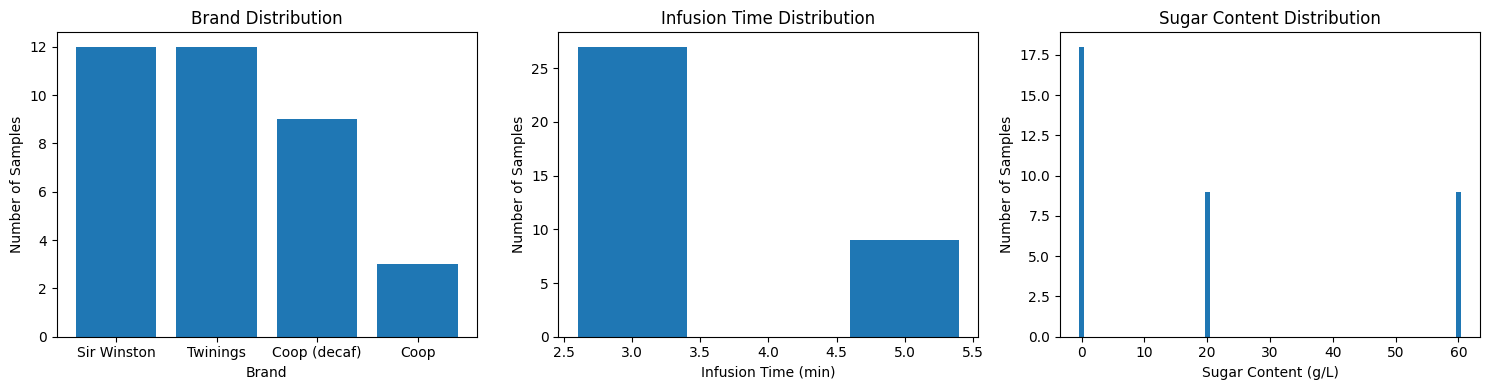

In [41]:
# Visualize distributions of metadata features
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
# Brand distribution
brand_counts = df_meta['brand'].value_counts()
axes[0].bar(brand_counts.index, brand_counts.values)
axes[0].set_title('Brand Distribution')
axes[0].set_xlabel('Brand')
axes[0].set_ylabel('Number of Samples')
# Infusion time distribution
infusion_counts = df_meta['infusion'].value_counts()
axes[1].bar(infusion_counts.index, infusion_counts.values)
axes[1].set_title('Infusion Time Distribution')
axes[1].set_xlabel('Infusion Time (min)')
axes[1].set_ylabel('Number of Samples')
# Sugar content distribution
sugar_counts = df_meta['sugar'].value_counts()
axes[2].bar(sugar_counts.index, sugar_counts.values)
axes[2].set_title('Sugar Content Distribution')
axes[2].set_xlabel('Sugar Content (g/L)')
axes[2].set_ylabel('Number of Samples')
plt.tight_layout()
plt.show()


## Spectral Visualization: Plot example raw spectra

Wavelengths type/shape: <class 'numpy.ndarray'> (1200,) [400.  400.5 401.  401.5 402. ]
X type/shape: <class 'numpy.ndarray'> (36, 1200) [1701.  1690.  1682.  1679.  1674.5]
Any NaNs? False False


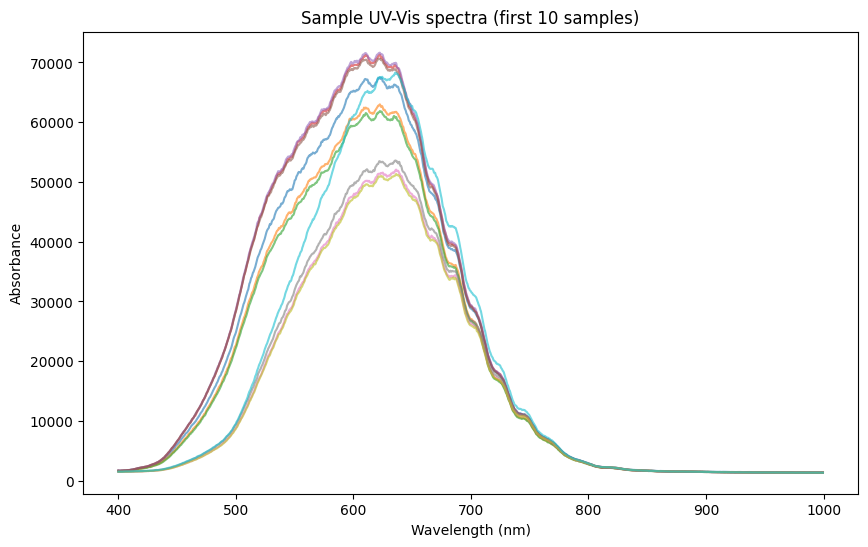

In [48]:
# convert object/string arrays to numeric for NaN checks and plotting
wl = wavelengths.astype(float)
X_num = X.astype(float)

plt.figure(figsize=(10, 6))

print("Wavelengths type/shape:", type(wavelengths), wavelengths.shape, wl[:5])
print("X type/shape:", type(X), X.shape, X_num[0][:5])
print("Any NaNs?", np.isnan(X_num).any(), np.isnan(wl).any())

for i in range(min(10, X_num.shape[0])):  # plot up to 10 samples
    plt.plot(wl, X_num[i], alpha=0.6)

plt.title("Sample UV-Vis spectra (first 10 samples)")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.show()



## Compare spectra grouped by metadata fields
### Spectra by  brand

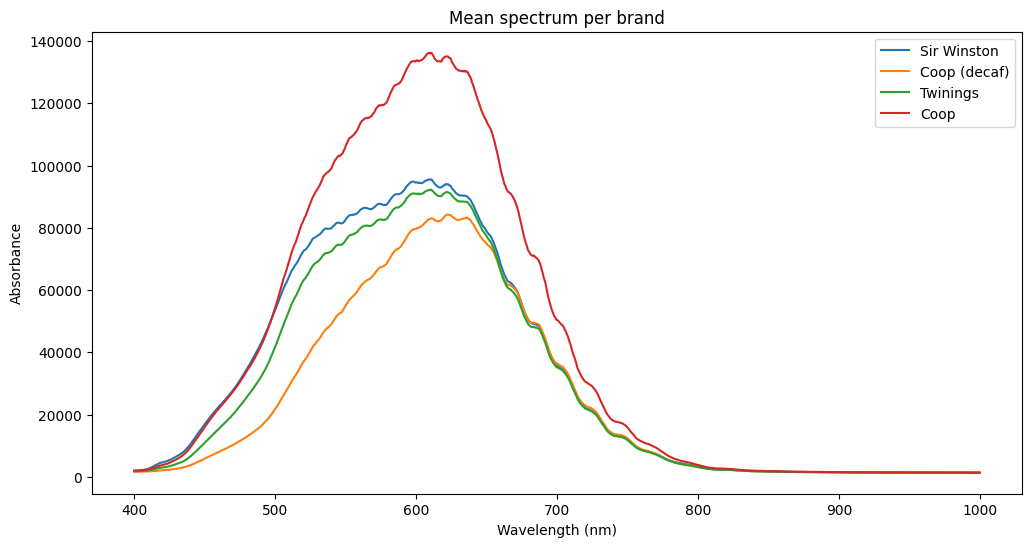

In [50]:
brands = df_meta["brand"].unique()

plt.figure(figsize=(12, 6))

# convert numeric arrays from string->float for the plot computations only
wl = wavelengths.astype(float)
for b in brands:
    idx = df_meta[df_meta["brand"] == b].index
    mean_spec = X[idx].astype(float).mean(axis=0)
    plt.plot(wl, mean_spec, label=b)

plt.title("Mean spectrum per brand")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.legend()
plt.show()


### Spectra by infusion time

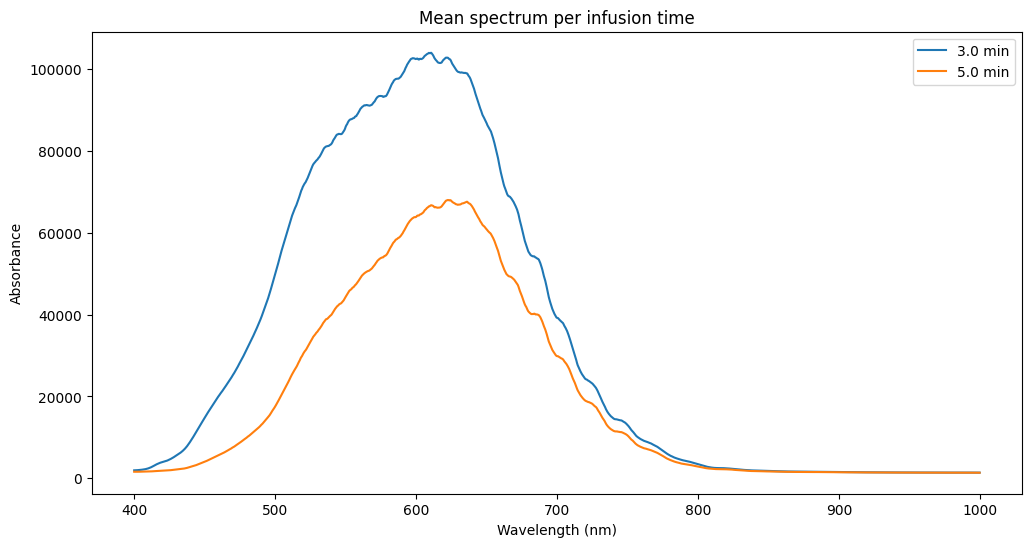

In [52]:
times = df_meta["infusion"].unique()

plt.figure(figsize=(12, 6))
wl = wavelengths.astype(float)  # Convert to float
for t in sorted(times):
    idx = df_meta[df_meta["infusion"] == t].index
    mean_spec = X[idx].astype(float).mean(axis=0)
    plt.plot(wl, mean_spec, label=f"{t} min")  # Use wl
plt.title("Mean spectrum per infusion time")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.legend()
plt.show()


### Variance across wavelengths

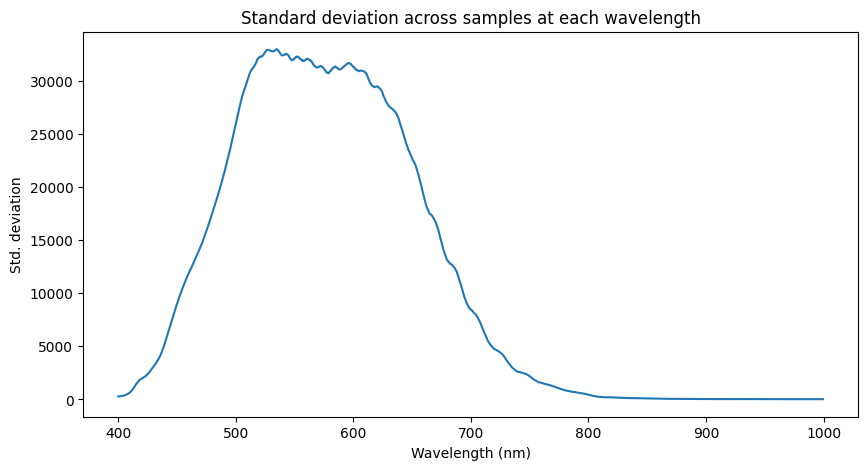

In [54]:
X_float = X.astype(float)
std_vals = X_float.std(axis=0)

plt.figure(figsize=(10, 5))
wl = wavelengths.astype(float)  # Convert to float for x-axis
plt.plot(wl, std_vals)
plt.title("Standard deviation across samples at each wavelength")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Std. deviation")
plt.show()


## Replicate comparison

Replicates from the same sample should have highly similar spectra.

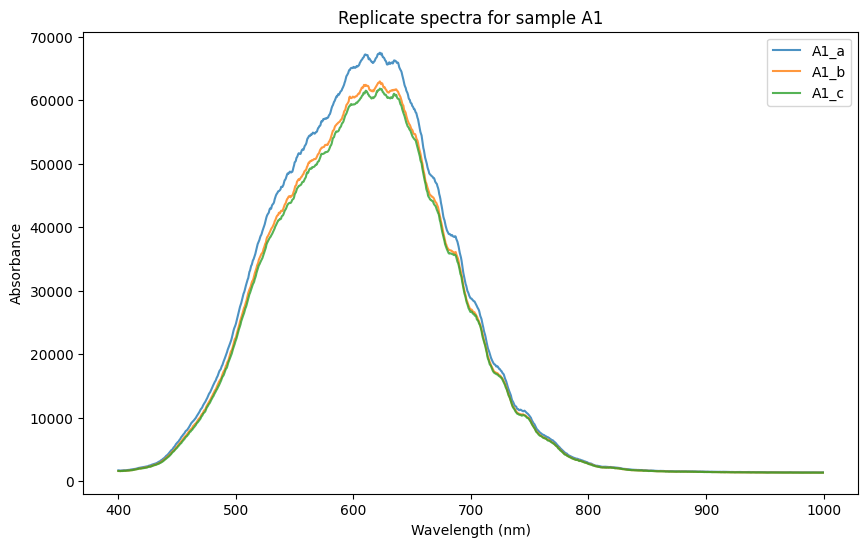

In [58]:
# example: pick the first sample with ≥ 2 replicates
bases = df_meta["base"].value_counts()
multi = bases[bases > 1].index[0]
idx = df_meta[df_meta["base"] == multi].index
plt.figure(figsize=(10, 6))
wl = wavelengths.astype(float)  # Convert to float
X_float = X.astype(float)  # Convert to float
for i in idx:
    plt.plot(wl, X_float[i], alpha=0.8, label=df_meta.iloc[i]["sample_id"])
plt.title(f"Replicate spectra for sample {multi}")
plt.xlabel("Wavelength (nm)")
plt.ylabel("Absorbance")
plt.legend()
plt.show()


## PCA projection of spectra

Principal Component Analysis (PCA) is a dimensionality reduction technique that transforms high-dimensional data into a lower-dimensional space by identifying the principal components—directions of maximum variance in the data. Here, we apply PCA to the spectral matrix X (36 samples × 1200 wavelengths) to reduce it to 2 dimensions for visualization, capturing the most significant patterns in the spectra.
### How PCA Works Here
- Input: The raw absorbance spectra across 1200 wavelengths (380–720 nm).
- Process: PCA computes eigenvectors (principal components) and eigenvalues (explained variance). The first component explains the most variance, the second the next most, and so on.
- Output: X_pca is a 2D array (36 × 2), where each row is a sample's coordinates in the new 2D space. These coordinates are the projections (dot products) of the original 1200-wavelength spectra onto the first two principal components, summarizing spectral variability in a lower-dimensional embedding.
- Visualization: The scatter plot uses the first two principal components as axes, colored by brand, to assess clustering. Points from the same brand grouping closely suggest spectral similarities, while separations indicate differences. This aids in exploratory data analysis, revealing if brands form distinct manifolds in spectral space, which could inform classification tasks.

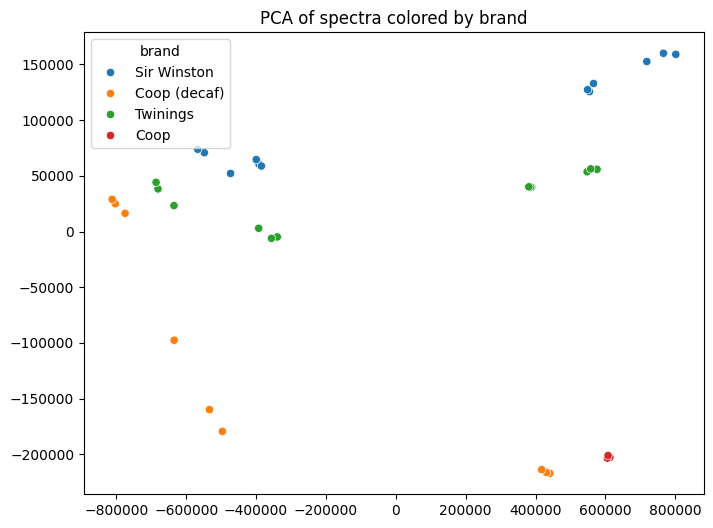

In [37]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=df_meta["brand"])
plt.title("PCA of spectra colored by brand")
plt.show()
